### Mount Google Drive and Install Packages

In [4]:
pip install tensorflow==2.15 keras==2.15 tensorflow-addons==0.21.0


Note: you may need to restart the kernel to use updated packages.


In [5]:
import tensorflow as tf
import cv2
import tensorflow_addons as tfa
import os

# Verify installations
print("TensorFlow Version:", tf.__version__)  # ✅ Corrected
print("OpenCV Version:", cv2.__version__)      # ✅ Corrected
print("TensorFlow Addons Version:", tfa.__version__)  # ✅ Added

# Check if dataset path exists (Modify this path based on your setup)
dataset_path = r"C:\Users\bathu\OneDrive\Desktop\Neolder\Human-Pose-Estimation\OCHuman\ochuman_images"
if not os.path.exists(dataset_path):
    print(f"⚠️ Warning: Dataset path {dataset_path} does not exist. Please verify the path.")
else:
    print(f"✅ Dataset path verified: {dataset_path}")

TensorFlow Version: 2.15.0
OpenCV Version: 4.11.0
TensorFlow Addons Version: 0.21.0
✅ Dataset path verified: C:\Users\bathu\OneDrive\Desktop\Neolder\Human-Pose-Estimation\OCHuman\ochuman_images


### Import Libraries and Load Data

✅ Image folder found: C:\Users\bathu\OneDrive\Desktop\Neolder\Human-Pose-Estimation\OCHuman\ochuman_images
✅ Loaded 2500 training images.
✅ Loaded 2231 testing images.
✅ Train dataset loaded! Total images: 2500
✅ Test dataset loaded! Total images: 2231


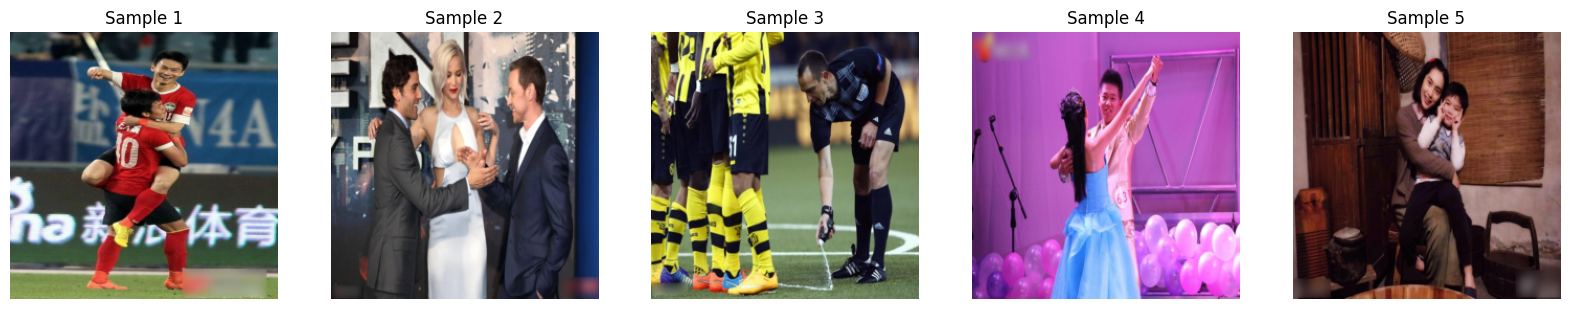

In [8]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

# 🔹 **Set Paths**
ROOT_DIR = r"C:\Users\bathu\OneDrive\Desktop\Neolder\Human-Pose-Estimation\OCHuman"
IMAGES_DIR = os.path.join(ROOT_DIR, "ochuman_images")  # Ensure images are here
TRAIN_ANNOTATIONS_PATH = os.path.join(ROOT_DIR, "ochuman_coco_format_val_range_0.00_1.00.json")
TEST_ANNOTATIONS_PATH = os.path.join(ROOT_DIR, "ochuman_coco_format_test_range_0.00_1.00.json")

# 🔹 **Verify Dataset Path**
if not os.path.exists(IMAGES_DIR):
    raise FileNotFoundError(f"❌ ERROR: Image folder not found at: {IMAGES_DIR}")

if not os.listdir(IMAGES_DIR):
    raise FileNotFoundError(f"❌ ERROR: Image folder is empty! Please check your dataset.")

print(f"✅ Image folder found: {IMAGES_DIR}")

# 🔹 **Load Annotations**
def load_annotations(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ ERROR: Annotation file not found at: {file_path}")

    with open(file_path, 'r') as f:
        data = json.load(f)

    if "images" not in data:
        raise ValueError(f"❌ ERROR: Incorrect annotation format in {file_path}")

    return data["images"]  # Extract only image-related data

train_data = load_annotations(TRAIN_ANNOTATIONS_PATH)
test_data = load_annotations(TEST_ANNOTATIONS_PATH)

print(f"✅ Loaded {len(train_data)} training images.")
print(f"✅ Loaded {len(test_data)} testing images.")

# 🔹 **Define Dataset Class**
class HumanPoseDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.valid_annotations = []

        for ann in self.annotations:
            img_path = os.path.join(self.img_dir, ann["file_name"])
            if os.path.exists(img_path):
                self.valid_annotations.append(ann)

        if len(self.valid_annotations) == 0:
            raise ValueError("❌ No valid images found! Check dataset path.")

    def __len__(self):
        return len(self.valid_annotations)

    def __getitem__(self, idx):
        ann = self.valid_annotations[idx]
        img_path = os.path.join(self.img_dir, ann["file_name"])

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"❌ Image not found: {img_path}")

        image = Image.open(img_path).convert("RGB")

        keypoints = np.array(ann.get("keypoints", [])).reshape(-1, 3)  # [x, y, visibility]
        keypoints = torch.tensor(keypoints, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, keypoints

# 🔹 **Image Transformations**
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 🔹 **Create Dataset and DataLoader**
train_dataset = HumanPoseDataset(train_data, IMAGES_DIR, transform)
test_dataset = HumanPoseDataset(test_data, IMAGES_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

print(f"✅ Train dataset loaded! Total images: {len(train_dataset)}")
print(f"✅ Test dataset loaded! Total images: {len(test_dataset)}")

# 🔹 **Display Sample Images**
def display_sample_images(loader, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for i, (image, keypoints) in enumerate(loader):
        if i >= num_samples:
            break
        
        img_np = image[0].permute(1, 2, 0).numpy()  # Convert tensor to NumPy
        axes[i].imshow(img_np)
        axes[i].axis("off")
        axes[i].set_title(f"Sample {i+1}")

    plt.show()

# 🔹 **Run the DataLoader & Display Sample**
display_sample_images(train_loader)

### Define Dataset Class and Transformations

✅ Loaded 2500 training images.
✅ Loaded 2231 testing images.
✅ Train dataset loaded! Total images: 4291
✅ Test dataset loaded! Total images: 3819


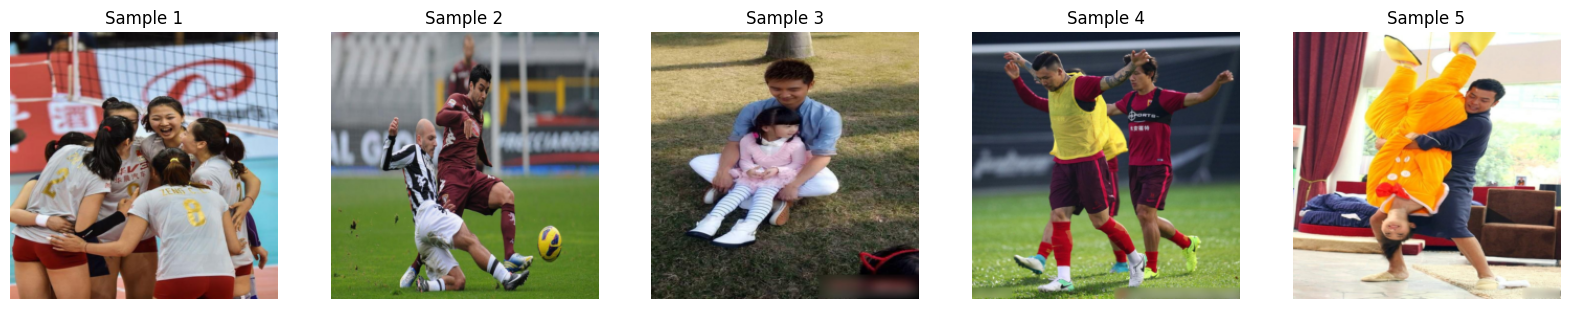

In [9]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# 🔹 **Set Paths**
ROOT_DIR = r"C:\Users\bathu\OneDrive\Desktop\Neolder\Human-Pose-Estimation\OCHuman"
IMAGES_DIR = os.path.join(ROOT_DIR, "ochuman_images")  # Ensure images are here
TRAIN_ANNOTATIONS_PATH = os.path.join(ROOT_DIR, "ochuman_coco_format_val_range_0.00_1.00.json")
TEST_ANNOTATIONS_PATH = os.path.join(ROOT_DIR, "ochuman_coco_format_test_range_0.00_1.00.json")

# 🔹 **Load Annotations**
def load_annotations(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ ERROR: Annotation file not found at: {file_path}")

    with open(file_path, 'r') as f:
        data = json.load(f)

    if "images" not in data or "annotations" not in data:
        raise ValueError(f"❌ ERROR: Incorrect annotation format in {file_path}")

    return data  # Keep the full dictionary

train_data = load_annotations(TRAIN_ANNOTATIONS_PATH)
test_data = load_annotations(TEST_ANNOTATIONS_PATH)

print(f"✅ Loaded {len(train_data['images'])} training images.")
print(f"✅ Loaded {len(test_data['images'])} testing images.")

# 🔹 **Define Dataset Class**
class HumanPoseDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations["annotations"]
        self.img_dir = img_dir
        self.transform = transform
        self.image_info = {image["id"]: image for image in annotations["images"]}
        self.valid_annotations = []

        for ann in self.annotations:
            img_id = ann["image_id"]
            if img_id in self.image_info:
                img_path = os.path.join(self.img_dir, self.image_info[img_id]["file_name"])
                if os.path.exists(img_path):
                    self.valid_annotations.append(ann)

        if len(self.valid_annotations) == 0:
            raise ValueError("❌ No valid images found! Check dataset path.")

    def __len__(self):
        return len(self.valid_annotations)

    def __getitem__(self, idx):
        ann = self.valid_annotations[idx]
        img_id = ann["image_id"]
        img_path = os.path.join(self.img_dir, self.image_info[img_id]["file_name"])

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"❌ Image not found: {img_path}")

        image = Image.open(img_path).convert("RGB")
        keypoints = torch.tensor(ann["keypoints"], dtype=torch.float32).view(-1, 3)  # Reshape & convert

        if self.transform:
            image = self.transform(image)

        return image, keypoints[:, :2].flatten()  # Keep (x, y) only

# 🔹 **Define Transformations**
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 🔹 **Create Dataset & DataLoader**
train_dataset = HumanPoseDataset(train_data, IMAGES_DIR, transform)
test_dataset = HumanPoseDataset(test_data, IMAGES_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"✅ Train dataset loaded! Total images: {len(train_dataset)}")
print(f"✅ Test dataset loaded! Total images: {len(test_dataset)}")

# 🔹 **Display Sample Images**
def display_sample_images(loader, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i, (image, keypoints) in enumerate(loader):
        if i >= num_samples:
            break

        img_np = image[0].permute(1, 2, 0).numpy()  # Convert tensor to NumPy
        axes[i].imshow(img_np)
        axes[i].axis("off")
        axes[i].set_title(f"Sample {i+1}")

    plt.show()

# 🔹 **Run the DataLoader & Display Sample**
display_sample_images(train_loader)

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class PoseEstimator(nn.Module):
    def __init__(self, num_keypoints):
        super(PoseEstimator, self).__init__()
        
        # Load pre-trained ResNet model
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove last FC layer
        
        # Custom head for keypoint prediction
        self.keypoint_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_keypoints * 2, kernel_size=1)  # Output (x, y) for each keypoint
        )

    def forward(self, x):
        x = self.backbone(x)  # Extract features
        x = self.keypoint_head(x)  # Predict keypoints
        x = x.view(x.shape[0], -1)  # Flatten output to (batch_size, num_keypoints * 2)
        return x

# 🔹 Define Number of Keypoints
num_keypoints = 17  # COCO format (17 keypoints)

# 🔹 Instantiate the model
model = PoseEstimator(num_keypoints)

# 🔹 Print model summary
print(model)

c:\Users\bathu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bathu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\bathu/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:16<00:00, 2.81MB/s]


PoseEstimator(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

### Define Model Architecture and Instantiate Model (RESNET MODEL)

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class PoseEstimator(nn.Module):
    def __init__(self, num_keypoints):
        super(PoseEstimator, self).__init__()
        
        # Load Pre-trained ResNet18
        self.resnet = models.resnet18(pretrained=True)
        
        # Get the number of input features for the final FC layer
        in_features = self.resnet.fc.in_features
        
        # Replace the classification head with a regression head (Keypoints)
        self.resnet.fc = nn.Linear(in_features, num_keypoints * 2)  # Output (x, y) for each keypoint

    def forward(self, x):
        return self.resnet(x)

# 🔹 Define number of keypoints (COCO format has 17 keypoints)
num_keypoints = 17

# 🔹 Instantiate the model
model = PoseEstimator(num_keypoints)

# 🔹 Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🔹 Print model summary
print(model)

PoseEstimator(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

### Define Loss Function and Optimizer, and Training Loop

In [13]:
import torch.optim as optim
import torch.nn as nn

# 🔹 Define loss function and optimizer
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# 🔹 Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🔹 Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    
    for i, (images, keypoints) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        images = images.to(device)
        keypoints = keypoints.to(device)

        # Flatten keypoints (batch_size, num_keypoints * 2) to match outputs
        keypoints = keypoints.view(keypoints.size(0), -1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, keypoints)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        # Print progress every 10 batches
        if i % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{total_batches}, Loss: {loss.item():.4f}')

    # Calculate average epoch loss
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'✅ Epoch {epoch+1}/{num_epochs} - Avg Loss: {epoch_loss:.4f}')

Epoch 1/5, Batch 1/269, Loss: 333.5604
Epoch 1/5, Batch 11/269, Loss: 296.3242
Epoch 1/5, Batch 21/269, Loss: 318.8546
Epoch 1/5, Batch 31/269, Loss: 280.5859
Epoch 1/5, Batch 41/269, Loss: 315.4892
Epoch 1/5, Batch 51/269, Loss: 277.8902
Epoch 1/5, Batch 61/269, Loss: 306.8674
Epoch 1/5, Batch 71/269, Loss: 233.9558
Epoch 1/5, Batch 81/269, Loss: 251.9362
Epoch 1/5, Batch 91/269, Loss: 239.1187
Epoch 1/5, Batch 101/269, Loss: 248.2849
Epoch 1/5, Batch 111/269, Loss: 265.5192
Epoch 1/5, Batch 121/269, Loss: 236.5293
Epoch 1/5, Batch 131/269, Loss: 230.8634
Epoch 1/5, Batch 141/269, Loss: 247.6594
Epoch 1/5, Batch 151/269, Loss: 215.2640
Epoch 1/5, Batch 161/269, Loss: 194.6534
Epoch 1/5, Batch 171/269, Loss: 167.0111
Epoch 1/5, Batch 181/269, Loss: 179.8340
Epoch 1/5, Batch 191/269, Loss: 182.1756
Epoch 1/5, Batch 201/269, Loss: 171.4044
Epoch 1/5, Batch 211/269, Loss: 188.6205
Epoch 1/5, Batch 221/269, Loss: 175.7166
Epoch 1/5, Batch 231/269, Loss: 139.5779
Epoch 1/5, Batch 241/269, L

### Define Evaluation Function and Evaluate the Model

In [17]:
import torch

# 🔹 Define evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    count = 0

    with torch.no_grad():  # Disable gradient computation
        for images, keypoints in test_loader:
            # ✅ Move data to device (GPU/CPU)
            images = images.to(device)
            keypoints = keypoints.to(device).view(keypoints.size(0), -1)  # Flatten keypoints

            # ✅ Forward pass
            outputs = model(images)
            loss = criterion(outputs, keypoints)

            # ✅ Accumulate loss
            total_loss += loss.item() * images.size(0)
            count += images.size(0)

    # ✅ Compute final average loss
    average_loss = total_loss / count
    print(f"✅ Mean Squared Error on the test set: {average_loss:.4f}")

# 🔹 Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🔹 Run evaluation
evaluate_model(model, test_loader, criterion, device)

✅ Mean Squared Error on the test set: 125.0373


In [18]:
!pip install mediapipe torch torchvision

### Perform Pose Estimation on Sample Images

In [23]:
import cv2
import mediapipe as mp
import os

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def estimate_pose(image_sample, display=True):
    # ✅ Check if file exists
    if not os.path.exists(image_sample):
        print(f"❌ Error: File not found - {image_sample}")
        return False, None

    # ✅ Read the image
    image = cv2.imread(image_sample)
    if image is None:
        print(f"❌ Error: Could not read image {image_sample}. Check the path.")
        return False, None

    # ✅ Convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # ✅ Initialize MediaPipe Pose
    with mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True) as pose:
        results = pose.process(image_rgb)

        # ✅ Check if pose landmarks are detected
        if not results.pose_landmarks:
            print("⚠️ No pose detected in the image.")
            return False, None

        # ✅ Draw landmarks on the image
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
        )

        # ✅ Resize image for better visualization
        annotated_image = cv2.resize(annotated_image, (600, 600))

        # ✅ Display the image if required
        if display:
            cv2.imshow("Pose Estimation", annotated_image)
            cv2.waitKey(1)  # Change 0 to 1 to prevent freezing
            cv2.destroyAllWindows()

        return True, results  # ✅ Return success flag & pose results

# 🔹 Example Usage
image_path = r"C:\Users\bathu\OneDrive\Desktop\Neolder\Human-Pose-Estimation\OCHuman\ochuman_images\000001.jpg"  
success, pose_results = estimate_pose(image_path)

if success:
    print("✅ Pose estimation completed successfully!")
else:
    print("❌ Pose estimation failed.")

✅ Pose estimation completed successfully!


✅ Found 5081 images in dataset.


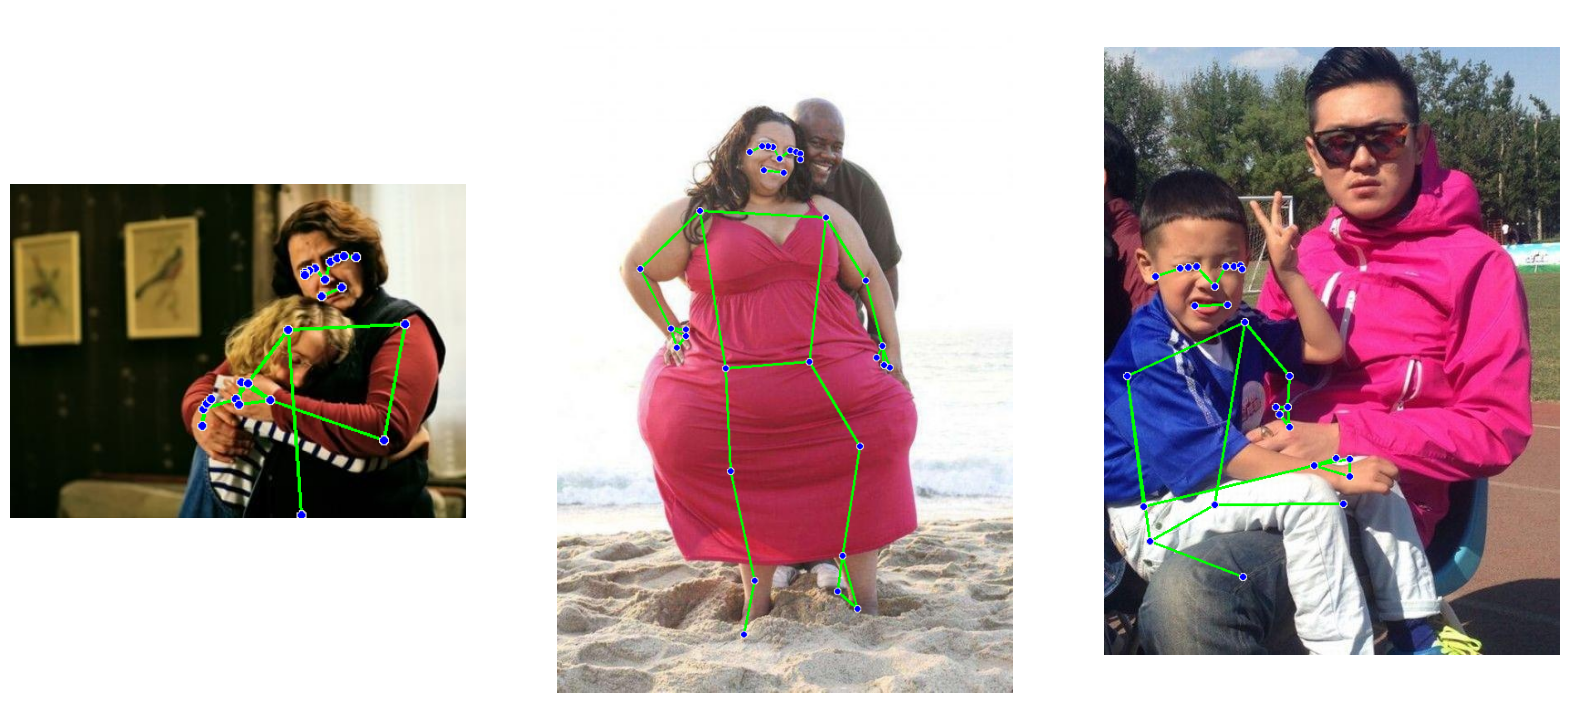

In [2]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# 🔹 Initialize MediaPipe Pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 🔹 Define dataset directory
images_data_root_dir = r"C:\Users\bathu\OneDrive\Desktop\Neolder\Human-Pose-Estimation\OCHuman\ochuman_images"

# ✅ Verify dataset path
if not os.path.exists(images_data_root_dir):
    raise FileNotFoundError(f"❌ Dataset directory not found: {images_data_root_dir}")

# ✅ List available images
available_images = [f for f in os.listdir(images_data_root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"✅ Found {len(available_images)} images in dataset.")

# ✅ Define function to estimate pose
def estimate_pose(image_path):
    if not os.path.exists(image_path):
        print(f"❌ Error: File not found - {image_path}")
        return None

    # Load and convert image to RGB
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run MediaPipe Pose estimation
    with mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True) as pose:
        results = pose.process(image_rgb)

        if not results.pose_landmarks:
            print(f"⚠️ No pose detected in {image_path}")
            return None

        # Draw landmarks
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
        )

        return cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)  # Convert back for Matplotlib

# ✅ Choose sample images (ensure they exist)
image_samples = available_images[:3]  # Pick first 3 available images
image_paths = [os.path.join(images_data_root_dir, img) for img in image_samples]

# ✅ Process multiple images
def process_images(image_paths):
    images = []
    for path in image_paths:
        annotated_img = estimate_pose(path)
        if annotated_img is not None:
            images.append(annotated_img)
    return images

# 🔹 Get annotated images
annotated_images = process_images(image_paths)

# ✅ Plot the pose estimation results
if annotated_images:
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(annotated_images):
        plt.subplot(1, len(annotated_images), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
else:
    print("❌ No images processed.")

In [3]:
# Save the trained model
torch.save(model.state_dict(), "model.pth")
print("✅ Model saved successfully!")

NameError: name 'torch' is not defined